## ResNet

ResNet, or Residual Network, is a deep learning architecture known for its ability to train very deep neural networks by using residual connections to mitigate the vanishing gradient problem. We will use ResNet in human scream detection due to its robustness in extracting complex features from audio spectrograms, enabling improved accuracy in distinguishing scream events from background noise.

In [ ]:
#Installing the needed libraries
!pip install librosa tensorflow matplotlib

### Importing libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
data_path = "/content/drive/My Drive/DeepLearning/code/dataset/"

X_train = np.load(data_path + 'X_train.npy')
X_val = np.load(data_path + 'X_val.npy')
X_test = np.load(data_path + 'X_test.npy')
y_train = np.load(data_path + 'y_train.npy')
y_val = np.load(data_path + 'y_val.npy')
y_test = np.load(data_path + 'y_test.npy')
X_train_da = np.load(data_path + 'X_train_da.npy')
y_train_da = np.load(data_path + 'y_train_da.npy')

In [5]:
def resnet_block(inputs, filters, kernel_size=3, strides=1):
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if strides != 1 or inputs.shape[-1] != filters:
        inputs = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(inputs)

    x = layers.add([x, inputs])
    x = layers.ReLU()(x)
    return x

# Define the ResNet-like model
def create_resnet(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Train the model with raw data

In [13]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
X_train = X_train.reshape((*X_train.shape, 1))
X_val = X_val.reshape((*X_val.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))

model = create_resnet(input_shape)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/50
88/88 [==============================] - 30s 239ms/step - loss: 0.5001 - accuracy: 0.7717 - val_loss: 2.3528 - val_accuracy: 0.7249
Epoch 2/50
88/88 [==============================] - 17s 189ms/step - loss: 0.4131 - accuracy: 0.8257 - val_loss: 1.7983 - val_accuracy: 0.5043
Epoch 3/50
88/88 [==============================] - 16s 186ms/step - loss: 0.3736 - accuracy: 0.8418 - val_loss: 31.4903 - val_accuracy: 0.2980
Epoch 4/50
88/88 [==============================] - 16s 186ms/step - loss: 0.3796 - accuracy: 0.8314 - val_loss: 2.2947 - val_accuracy: 0.2980
Epoch 5/50
88/88 [==============================] - 16s 186ms/step - loss: 0.3514 - accuracy: 0.8500 - val_loss: 0.4055 - val_accuracy: 0.8424
Epoch 6/50
88/88 [==============================] - 16s 186ms/step - loss: 0.3392 - accuracy: 0.8608 - val_loss: 0.4677 - val_accuracy: 0.8166
Epoch 7/50
88/88 [==============================] - 16s 187ms/step - loss: 0.3259 - accuracy: 0.8651 - val_loss: 0.5366 - val_accuracy: 0.851

The **training accuracy** starts at around 78% and reaches up to 90% by the end of training. This indicates that the model is learning to classify the training data quite well over time.

The **validation accuracy** starts around 70% and fluctuates, reaching peaks around 87% in later epochs. This variability suggests that the model might be overfitting initially but stabilizes somewhat as training progresses.


### Evaluate the model with raw data

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes))

11/11 [==============================] - 1s 61ms/step - loss: 0.3960 - accuracy: 0.8543
Test accuracy: 0.854285717010498
11/11 [==============================] - 1s 51ms/step
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       252
           1       0.82      0.61      0.70        98

    accuracy                           0.85       350
   macro avg       0.84      0.78      0.80       350
weighted avg       0.85      0.85      0.85       350



11/11 [==============================] - 1s 61ms/step


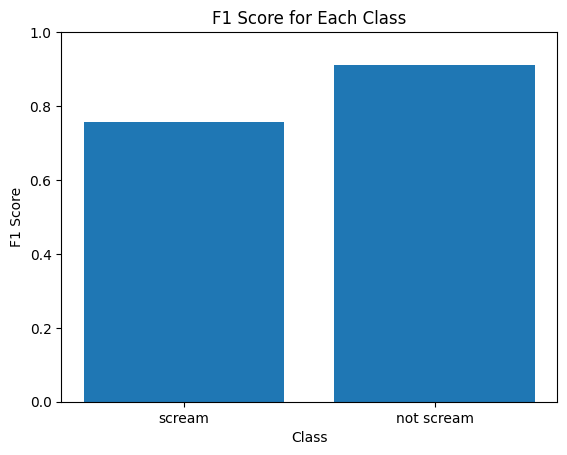

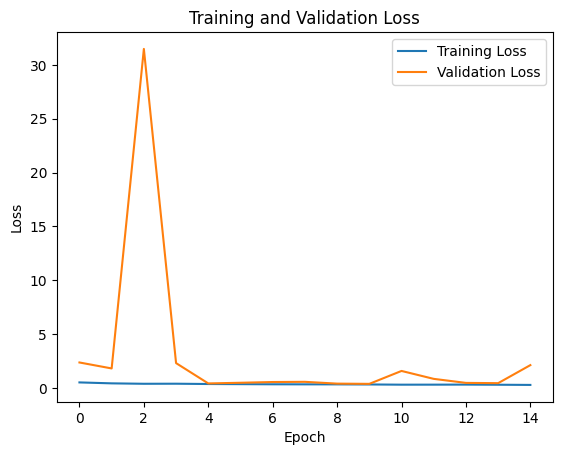

In [15]:
y_pred_val = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)

f1_scores = classification_report(np.argmax(y_val, axis=1), y_pred_val_classes, target_names=['not scream', 'scream'], output_dict=True)

f1_scream = f1_scores['scream']['f1-score']
f1_not_scream = f1_scores['not scream']['f1-score']

plt.bar(['scream', 'not scream'], [f1_scream, f1_not_scream])
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class')
plt.ylim(0, 1.0)  # Set y-axis limit for consistency
plt.show()

# Plot training history: loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


An **F1-score of class 0** is 0.91 and indicates a good balance between precision and recall for 'not scream' class.

The **F1-score for class 1** is 0.78, indicating a reasonable balance between precision and recall for 'scream' class.

The **training loss** starts relatively high at the beginning and steadily decreases over epochs. This decreasing trend indicates that the model is effectively minimizing the error on the training data as it learns.

The **validation loss** shows more variability but generally decreases over the epochs. There are spikes in validation loss in some epochs (e.g., epochs 2, 4, 5), which suggests that the model might encounter challenges in generalizing to the validation data during those epochs.

11/11 [==============================] - 1s 54ms/step


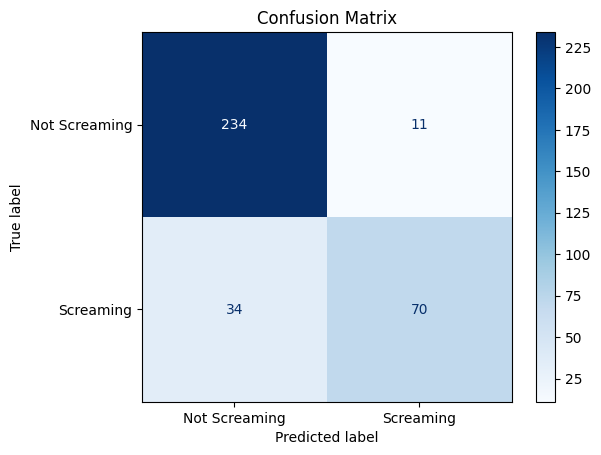

In [16]:
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))

y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred)

labels = ['Not Screaming', 'Screaming']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Proceed with training the model using the dataset that includes data augmentation.

In [6]:
input_shape = (X_train_da.shape[1], X_train_da.shape[2], 1)
X_train_da = X_train_da.reshape((*X_train_da.shape, 1))
X_val = X_val.reshape((*X_val.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))

model = create_resnet(input_shape)
history = model.fit(X_train_da, y_train_da, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/50
132/132 [==============================] - 51s 228ms/step - loss: 0.5539 - accuracy: 0.7468 - val_loss: 0.7198 - val_accuracy: 0.7479
Epoch 2/50
132/132 [==============================] - 26s 194ms/step - loss: 0.4566 - accuracy: 0.8036 - val_loss: 20.9847 - val_accuracy: 0.2980
Epoch 3/50
132/132 [==============================] - 25s 192ms/step - loss: 0.4191 - accuracy: 0.8238 - val_loss: 1.1256 - val_accuracy: 0.6418
Epoch 4/50
132/132 [==============================] - 24s 185ms/step - loss: 0.3827 - accuracy: 0.8397 - val_loss: 0.5778 - val_accuracy: 0.7966
Epoch 5/50
132/132 [==============================] - 24s 185ms/step - loss: 0.3417 - accuracy: 0.8587 - val_loss: 1.4377 - val_accuracy: 0.5043
Epoch 6/50
132/132 [==============================] - 25s 186ms/step - loss: 0.3364 - accuracy: 0.8620 - val_loss: 1.4936 - val_accuracy: 0.7794
Epoch 7/50
132/132 [==============================] - 25s 186ms/step - loss: 0.3215 - accuracy: 0.8755 - val_loss: 0.4064 - val_a

### Evaluate the model with raw dataset that includes data augmentation.

In [7]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred_classes))

11/11 [==============================] - 2s 219ms/step - loss: 0.4111 - accuracy: 0.8429
Test accuracy: 0.8428571224212646
11/11 [==============================] - 1s 52ms/step
              precision    recall  f1-score   support

           0       0.94      0.84      0.88       252
           1       0.67      0.86      0.75        98

    accuracy                           0.84       350
   macro avg       0.80      0.85      0.82       350
weighted avg       0.86      0.84      0.85       350



11/11 [==============================] - 1s 58ms/step


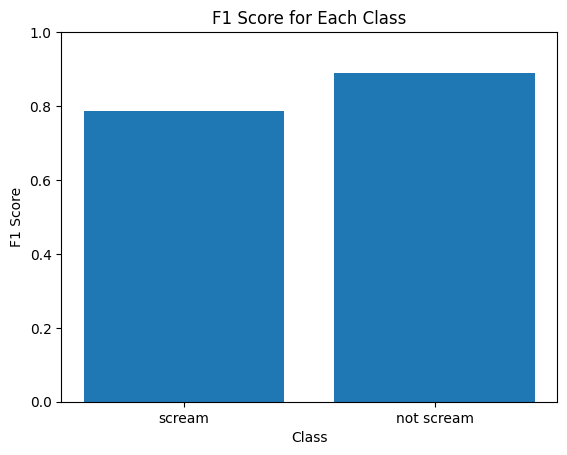

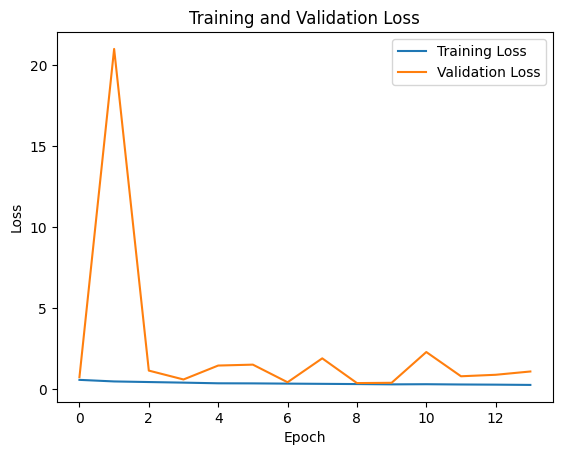

In [8]:
y_pred_val = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)

f1_scores = classification_report(np.argmax(y_val, axis=1), y_pred_val_classes, target_names=['not scream', 'scream'], output_dict=True)

f1_scream = f1_scores['scream']['f1-score']
f1_not_scream = f1_scores['not scream']['f1-score']

plt.bar(['scream', 'not scream'], [f1_scream, f1_not_scream])
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class')
plt.ylim(0, 1.0)  # Set y-axis limit for consistency
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


11/11 [==============================] - 1s 60ms/step


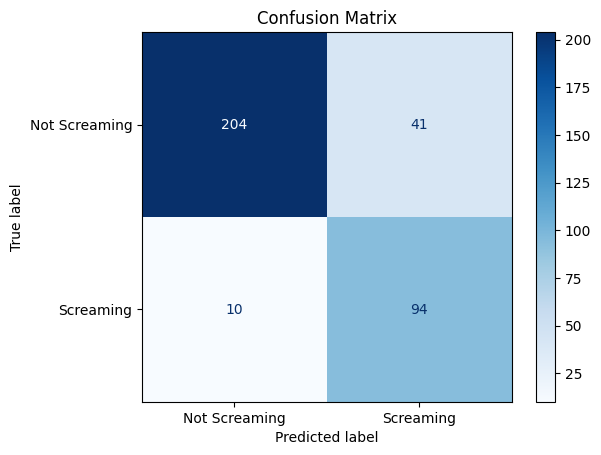

In [9]:
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))

y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred)

labels = ['Not Screaming', 'Screaming']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Train the model with Weight Loss Function to raw data

In [10]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

model = create_resnet(input_shape)

y_train_labels = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

history_weighted = model.fit(X_train, y_train, epochs=50, batch_size=32,
                             validation_data=(X_val, y_val),
                             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                             class_weight=class_weights_dict)


Class Weights: {0: 0.654639175257732, 1: 2.1166666666666667}
Epoch 1/50
88/88 [==============================] - 29s 235ms/step - loss: 0.6218 - accuracy: 0.7137 - val_loss: 3.6352 - val_accuracy: 0.2980
Epoch 2/50
88/88 [==============================] - 17s 190ms/step - loss: 0.4827 - accuracy: 0.7963 - val_loss: 4.9163 - val_accuracy: 0.3438
Epoch 3/50
88/88 [==============================] - 17s 189ms/step - loss: 0.4838 - accuracy: 0.8053 - val_loss: 4.2043 - val_accuracy: 0.3152
Epoch 4/50
88/88 [==============================] - 16s 186ms/step - loss: 0.4432 - accuracy: 0.8157 - val_loss: 7.3930 - val_accuracy: 0.3037
Epoch 5/50
88/88 [==============================] - 16s 186ms/step - loss: 0.4033 - accuracy: 0.8368 - val_loss: 2.1669 - val_accuracy: 0.3553
Epoch 6/50
88/88 [==============================] - 16s 187ms/step - loss: 0.3933 - accuracy: 0.8182 - val_loss: 0.4021 - val_accuracy: 0.8223
Epoch 7/50
88/88 [==============================] - 17s 189ms/step - loss: 0.3657

### Evaluate the model with raw dataset and Weight Loss Function.

In [11]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred_classes))

11/11 [==============================] - 1s 59ms/step - loss: 0.4425 - accuracy: 0.8086
Test accuracy: 0.808571457862854
11/11 [==============================] - 1s 54ms/step
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       252
           1       0.77      0.45      0.57        98

    accuracy                           0.81       350
   macro avg       0.79      0.70      0.72       350
weighted avg       0.80      0.81      0.79       350



11/11 [==============================] - 1s 57ms/step


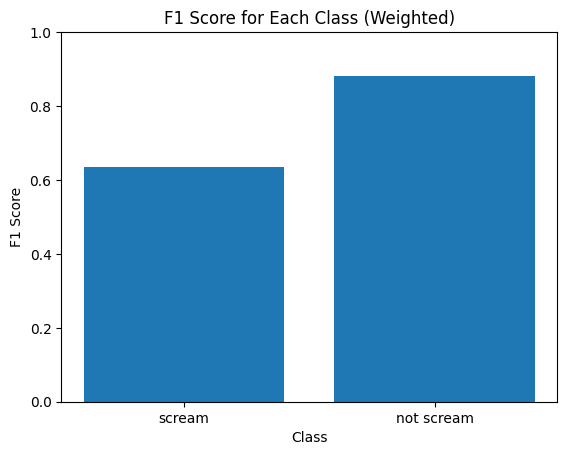

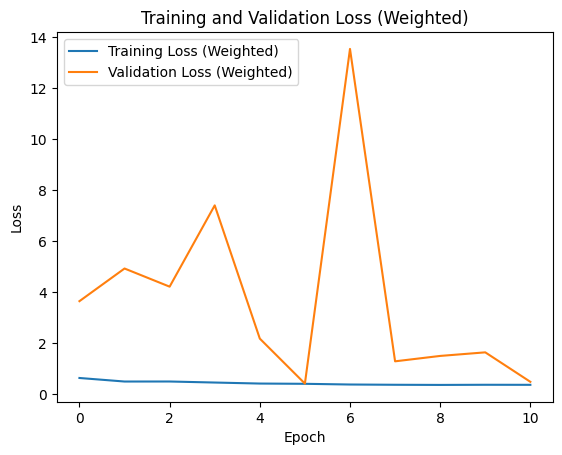

In [12]:
y_pred_val = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)
f1_scores_weighted = classification_report(np.argmax(y_val, axis=1), y_pred_val_classes,
                                           target_names=['not scream', 'scream'],
                                           output_dict=True)

f1_scream_weighted = f1_scores_weighted['scream']['f1-score']
f1_not_scream_weighted = f1_scores_weighted['not scream']['f1-score']

plt.bar(['scream', 'not scream'], [f1_scream_weighted, f1_not_scream_weighted])
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class (Weighted)')
plt.ylim(0, 1.0)
plt.show()

# Plot training history: loss
plt.plot(history_weighted.history['loss'], label='Training Loss (Weighted)')
plt.plot(history_weighted.history['val_loss'], label='Validation Loss (Weighted)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Weighted)')
plt.show()

11/11 [==============================] - 1s 57ms/step


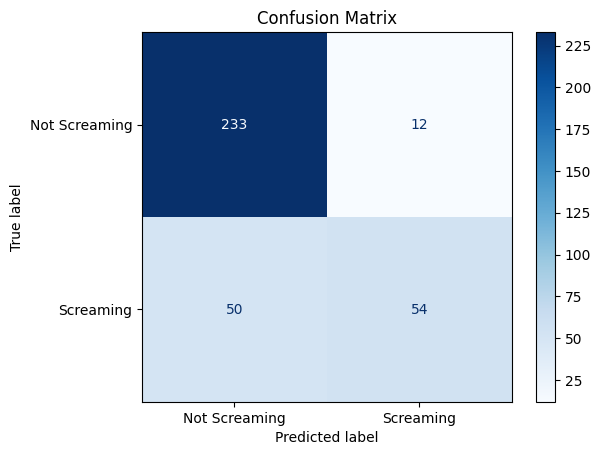

In [13]:
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))

y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred)

labels = ['Not Screaming', 'Screaming']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Train the model with Weight Loss Function to data of data augmentation

In [7]:
input_shape = (X_train_da.shape[1], X_train_da.shape[2], 1)
X_train_da = X_train_da.reshape((X_train_da.shape[0], X_train_da.shape[1], X_train_da.shape[2], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

model = create_resnet(input_shape)

# Assuming y_train contains binary labels (0 and 1)
y_train_labels = np.argmax(y_train_da, axis=1)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Fit the model with class weights
history_weighted = model.fit(X_train_da, y_train_da, epochs=50, batch_size=32,
                             validation_data=(X_val, y_val),
                             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                             class_weight=class_weights_dict)


Class Weights: {0: 0.822265625, 1: 1.2757575757575759}
Epoch 1/50
132/132 [==============================] - 49s 224ms/step - loss: 0.5706 - accuracy: 0.7325 - val_loss: 2.8411 - val_accuracy: 0.3037
Epoch 2/50
132/132 [==============================] - 24s 181ms/step - loss: 0.4359 - accuracy: 0.8209 - val_loss: 7.6162 - val_accuracy: 0.3295
Epoch 3/50
132/132 [==============================] - 24s 186ms/step - loss: 0.4026 - accuracy: 0.8314 - val_loss: 0.4288 - val_accuracy: 0.8510
Epoch 4/50
132/132 [==============================] - 25s 186ms/step - loss: 0.3807 - accuracy: 0.8409 - val_loss: 0.6261 - val_accuracy: 0.7765
Epoch 5/50
132/132 [==============================] - 24s 184ms/step - loss: 0.3419 - accuracy: 0.8606 - val_loss: 0.4858 - val_accuracy: 0.8080
Epoch 6/50
132/132 [==============================] - 24s 185ms/step - loss: 0.3511 - accuracy: 0.8556 - val_loss: 5.5851 - val_accuracy: 0.7020
Epoch 7/50
132/132 [==============================] - 24s 186ms/step - loss

### Evaluate the model with raw dataset that includes data augmentation and Weight Loss Function.

In [8]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes))


11/11 [==============================] - 2s 221ms/step - loss: 0.4391 - accuracy: 0.8686
Test accuracy: 0.868571400642395
11/11 [==============================] - 1s 51ms/step
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       252
           1       0.79      0.72      0.76        98

    accuracy                           0.87       350
   macro avg       0.84      0.82      0.83       350
weighted avg       0.87      0.87      0.87       350



11/11 [==============================] - 1s 64ms/step


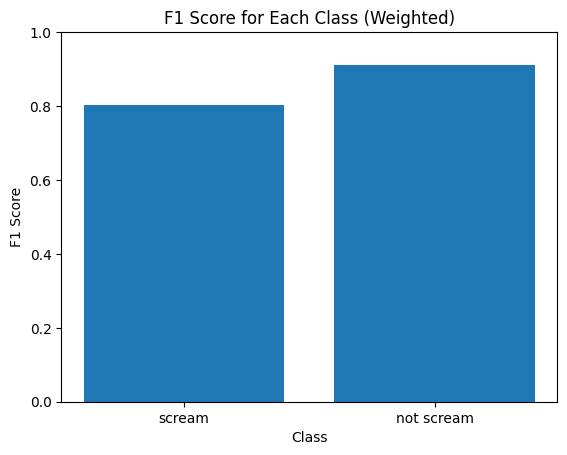

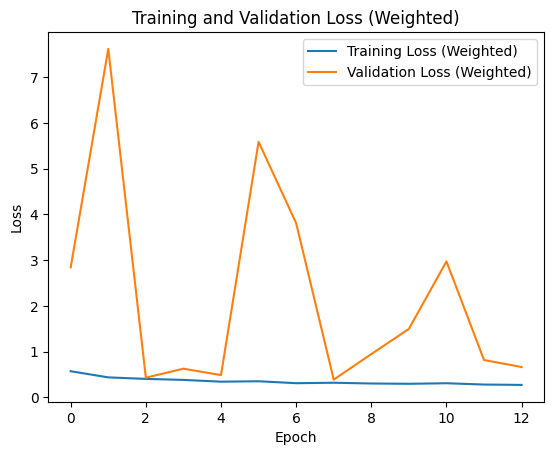

In [10]:
y_pred_val = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)
f1_scores_weighted = classification_report(np.argmax(y_val, axis=1), y_pred_val_classes,
                                           target_names=['not scream', 'scream'],
                                           output_dict=True)

f1_scream_weighted = f1_scores_weighted['scream']['f1-score']
f1_not_scream_weighted = f1_scores_weighted['not scream']['f1-score']

plt.bar(['scream', 'not scream'], [f1_scream_weighted, f1_not_scream_weighted])
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class (Weighted)')
plt.ylim(0, 1.0)
plt.show()

# Plot training history: loss
plt.plot(history_weighted.history['loss'], label='Training Loss (Weighted)')
plt.plot(history_weighted.history['val_loss'], label='Validation Loss (Weighted)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Weighted)')
plt.show()

11/11 [==============================] - 1s 59ms/step


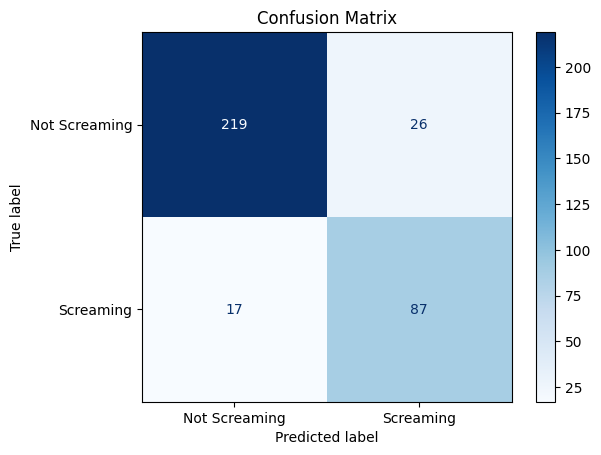

In [11]:
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))

y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred)

labels = ['Not Screaming', 'Screaming']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()